xG is essentially the probability that a particular shot will result in a goal, based on data from many different matches and shots.

xG can provide insights into a match beyond the scoreline, help predict future goals better than past goals, guide players and coaches in decision-making, and serve as a foundation for more complex football data models.


To build an expected goals model, we'd typically need information on:

Whether each event was a shot.
Whether each shot resulted in a goal.
The location from which each shot was taken.
Possibly other factors like the player taking the shot, the type of assist that led to the shot, etc.


Wyscout assumes that the pitch is 100 units long and 100 units wide, with the origin (0,0) at the center of the pitch and the goal at (100,50). We convert the pitch coordinates from percentages to an actual size of 105m x 68m.

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from time import time
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score

import os

In [2]:
# # Load the data
# data_euro = pd.read_json('events_European_Championship.json')
# # Load the World Cup data
# data_wc = pd.read_json('events_World_Cup.json')
# # Load the Germany data
# data_germany = pd.read_json('events_Germany.json')
# # Load the English data
# data_england = pd.read_json('events_England.json')



# # Combine the two datasets
# data = pd.concat([data_euro, data_wc, data_germany, data_england])

# # Check the shape of the combined dataset
# data.shape

In [3]:
# Define the directory where the JSON files are located
directory = 

# Initialize an empty DataFrame to store the data
data = pd.DataFrame()

# Loop through all JSON files in the directory
for filename in os.listdir(directory):
    # Check if the file is a JSON file
    if filename.endswith('.json'):
        # Construct the full file path
        filepath = os.path.join(directory, filename)
        # Load the data from the JSON file
        data_temp = pd.read_json(filepath)
        # Append the data to the main DataFrame
        data = pd.concat([data, data_temp])

# Check the shape of the combined dataset
data.shape

(3251294, 12)

In [4]:
# Show the first few records to understand the structure
data.head(2)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172


In [5]:
event_names = set(data['eventName'])
event_names

{'Duel',
 'Foul',
 'Free Kick',
 'Goalkeeper leaving line',
 'Interruption',
 'Offside',
 'Others on the ball',
 'Pass',
 'Save attempt',
 'Shot'}

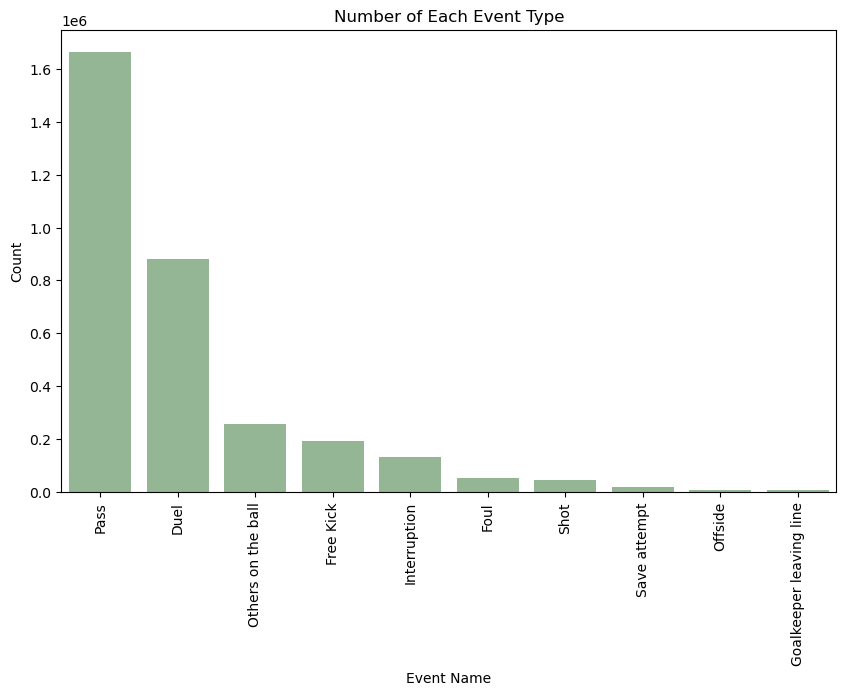

In [6]:
# Count the number of each event type
event_counts = data['eventName'].value_counts()

# Plot the number of each event type
plt.figure(figsize=(10, 6))
sns.barplot(x=event_counts.index, y=event_counts.values, color='darkseagreen')
plt.xlabel('Event Name')
plt.ylabel('Count')
plt.title('Number of Each Event Type')
plt.xticks(rotation=90)
plt.show()

In [7]:
# Get a general information about the DataFrame
data_info = data.info()

data_info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3251294 entries, 0 to 101758
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   eventId       int64  
 1   subEventName  object 
 2   tags          object 
 3   playerId      int64  
 4   positions     object 
 5   matchId       int64  
 6   eventName     object 
 7   teamId        int64  
 8   matchPeriod   object 
 9   eventSec      float64
 10  subEventId    object 
 11  id            int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 322.5+ MB


In [8]:
# Check for missing values in the DataFrame
data.isnull().sum()

eventId         0
subEventName    0
tags            0
playerId        0
positions       0
matchId         0
eventName       0
teamId          0
matchPeriod     0
eventSec        0
subEventId      0
id              0
dtype: int64

We will focus then only on shots excluding headers, free kicks, and penalties.

In [9]:
# Filter only shot events
shot_df = data.loc[data['subEventName'] == 'Shot'].copy()
shot_df.head(2)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212
62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247


In [10]:
# Count the total number of shots
num_shots = shot_df.shape[0]

num_shots

43078

For an xGoals model, we're interested in "Shot" events.  The tags field can also be important, as it might contain information about whether the shot resulted in a goal, which would be our target variable.

We'll extract the following features from each shot event:

distance_to_goal: the Euclidean distance from the starting position of the shot to the goal

angle_to_goal: the angle from the starting position of the shot to the goal

matchPeriod: the period of the match when the event happened, encoded as 0 for first half and 1 for second half

eventSec: the time when the event happened in seconds

The target variable will be whether the shot resulted in a goal, which can be extracted from the tags field. If the tags field contains a dictionary with 'id': 101 (indicating a goal), the target variable will be 1; otherwise, it will be 0.


Distance to the goal: This is a crucial feature because, generally, the closer a player is to the goal, the more likely they are to score.

Angle to the goal: This is another essential feature. The angle to the goal from the position of the shot can greatly influence the likelihood of a goal. If a player is directly in front of the goal, they will have a large angle and a better chance of scoring than if they were at a tight angle to the goal. The larger the angle (i.e., the more of the goal you can see), the greater the probability of scoring.

Match period: It might be helpful to consider the time of the match when the shot was made. Players might be more tired and make mistakes near the end of each half, which might influence the likelihood of a goal.

Time elapsed in the current match period (eventSec): This is the time elapsed in the current half or overtime period at the time of the shot. Similar to match_period, this could capture effects related to player fatigue.


It's worth noting that there are many other factors that can influence the likelihood of a shot resulting in a goal, and ideally you would want to include as many of them as possible in your model. These can include player skills, goalkeeper skills, game situation, pressure on the player, speed of play, and many others.

In [11]:
shot_df["X"] = shot_df['positions'].apply(lambda cell: (100 - cell[0]['x']) * 105/100)
shot_df["Y"] = shot_df['positions'].apply(lambda cell: cell[0]['y'] * 68/100)
shot_df["C"] = shot_df['positions'].apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)

- The 'X' column represents the transformed x-coordinate on a 105x68 pitch with the goal at x=0.
- The 'Y' column represents the transformed y-coordinate on a 105x68 pitch.
- The 'C' column represents the absolute distance from the centerline of the pitch.

All the shots are taken in the direction of increasing X (i.e., towards the right), which means the shots are all on the left side of the pitch since the goal is treated as x=0. 

In [12]:
def calculate_distance_to_goal(X, C):
    """Calculate the Euclidean distance from a position to the goal."""
    return np.sqrt(X**2 + C**2)

def calculate_angle_to_goal(X, C):
    """Calculate the angle from a position to the goal."""
    return np.where(np.arctan(7.32 * X / (X**2 + C**2 - (7.32/2)**2)) > 0, 
                    np.arctan(7.32 * X /(X**2 + C**2 - (7.32/2)**2)), 
                    np.arctan(7.32 * X /(X**2 + C**2 - (7.32/2)**2)) + np.pi)

def extract_features_and_target(shot_df):
    """Extract features and target from a DataFrame of shot events."""
    # Calculate features
    shot_df['distance_to_goal'] = calculate_distance_to_goal(shot_df['X'], shot_df['C'])
    shot_df['angle_to_goal'] = calculate_angle_to_goal(shot_df['X'], shot_df['C'])
#     shot_df['distance_angle_sum'] = shot_df['distance_to_goal'] + shot_df['angle_to_goal']
#     shot_df['match_period'] = (shot_df['matchPeriod'] == '2H').astype(int)
    
    # Determine whether the shot resulted in a goal
    shot_df['is_goal'] = shot_df['tags'].apply(lambda tags: any(tag['id'] == 101 for tag in tags))
    shot_df['is_goal'] = shot_df['is_goal'].astype(int)
    
    return shot_df[['distance_to_goal', 'angle_to_goal', 'is_goal']]

# Extract features and target from the shot events
df = extract_features_and_target(shot_df)

df.head()


,distance_to_goal,angle_to_goal,is_goal
46,14.007655,0.467241,1
62,15.808608,0.453557,0
91,4.414703,1.375115,1
128,23.057235,0.274666,0
249,29.563872,0.219665,0


In [13]:
# Get statistical summary of the numerical columns
df.describe().style.background_gradient()

,distance_to_goal,angle_to_goal,is_goal
count,43078.000000,43078.000000,43078.000000
mean,18.592949,0.414428,0.104276
std,8.419041,0.254495,0.305622
min,0.680000,0.040088,0.000000
25%,12.249445,0.250988,0.000000
50%,17.153297,0.327782,0.000000
75%,24.936000,0.505984,0.000000
max,103.952224,3.141593,1.000000


In [14]:
# Check for missing values in the DataFrame
df.isnull().sum()

distance_to_goal    0
angle_to_goal       0
is_goal             0
dtype: int64

In [15]:
df.nunique()

distance_to_goal    1491
angle_to_goal       1485
is_goal                2
dtype: int64

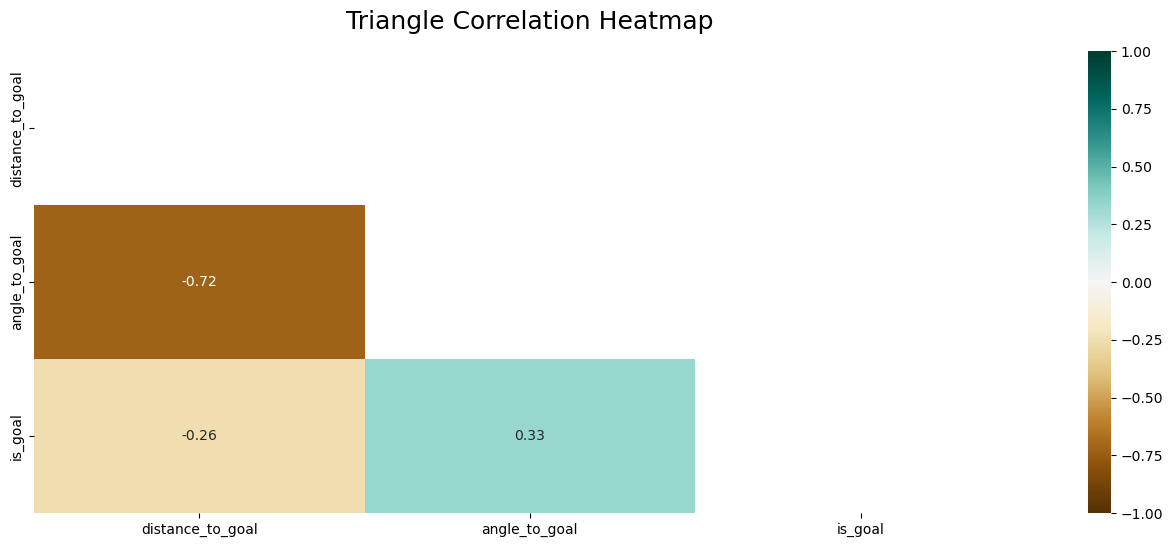

In [16]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(),
                      mask=mask,
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap',
                  fontdict={'fontsize': 18},
                  pad=16)
plt.show()

In [17]:

# # Create a figure with two subplots
# fig, axs = plt.subplots(2, figsize=(10, 8))

# # Plot histogram for distance_to_goal
# axs[0].hist(df['distance_to_goal'], bins=20, edgecolor='black', color='darkseagreen')
# axs[0].set_title('Histogram of Distance to Goal')
# axs[0].set_xlabel('Distance to Goal')
# axs[0].set_ylabel('Frequency')

# # Plot histogram for angle_to_goal
# axs[1].hist(df['angle_to_goal'], bins=20, edgecolor='black', color='darkseagreen')
# axs[1].set_title('Histogram of Angle to Goal')
# axs[1].set_xlabel('Angle to Goal')
# axs[1].set_ylabel('Frequency')

# # Adjust the layout
# plt.tight_layout()
# plt.show()

comment

In [18]:
# # Plot distributions of distance to goal and angle to goal for shot events

# fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# # Distance to goal
# sns.histplot(df['distance_to_goal'], bins=30, kde=True, ax=ax[0], color='darkseagreen')
# ax[0].set_title('Distance to Goal Distribution for Shot Events')
# ax[0].set_xlabel('Distance to Goal')
# ax[0].set_ylabel('Count')

# # Angle to goal
# sns.histplot(df['angle_to_goal'], bins=30, kde=True, ax=ax[1], color='darkseagreen')
# ax[1].set_title('Angle to Goal Distribution for Shot Events')
# ax[1].set_xlabel('Angle to Goal')
# ax[1].set_ylabel('Count')

# plt.tight_layout()
# plt.show()

We create 
- a 2D histogram (heatmap) to show the frequency of shots from different locations on the pitch. This will help us understand where players are most likely to take shots from.
- heatmap of goal locations. This can be used to identify areas of the pitch from which goals are commonly scored.
- heatmap of probability of a shot resulting in a goal from each location on the pitch, which is essentially the basis of the Expected Goals model. 

In [19]:
# # Function to draw a simple football pitch
# def draw_pitch():
#     fig, ax = plt.subplots(figsize=(10, 6))

#     # Set the limits of the pitch
#     plt.xlim(0, 105)
#     plt.ylim(0, 68)

#     # Draw the boundaries of the pitch
#     plt.plot([0, 0, 105, 105, 0], [0, 68, 68, 0, 0], color="black")

#     return fig, ax

In [20]:
# def plot_shot_map(df):
#     """Plot a heatmap of shot locations on a football pitch."""
#     # Draw the pitch
#     fig, ax = draw_pitch()

#     # Create a 2D histogram (i.e., a heatmap) of the shot locations
#     heatmap, _, _ = np.histogram2d(shot_df['X'], shot_df['Y'], bins=50, range=[[0, 105],[0, 68]])

#     # Plot the heatmap
#     pos = ax.imshow(heatmap.T, extent=[0, 105, 68, 0], origin='lower', aspect='auto', cmap=plt.cm.Reds)
#     fig.colorbar(pos, ax=ax)

#     # Set the title
#     fig.suptitle('Shot map' , fontsize = 20)

#     # Show the plot
#     plt.show()

# def plot_goal_map(goals_only):
#     """Plot a heatmap of goal locations on a football pitch."""
#     # Draw the pitch
#     fig, ax = draw_pitch()

#     # Create a 2D histogram (i.e., a heatmap) of the goal locations
#     heatmap_goals, _, _ = np.histogram2d(goals_only['X'], goals_only['Y'], bins=50, range=[[0, 105],[0, 68]])

#     # Plot the heatmap
#     pos = ax.imshow(heatmap_goals.T, extent=[0, 105, 68, 0], origin='lower', aspect='auto', cmap=plt.cm.Reds)
#     fig.colorbar(pos, ax=ax)

#     # Set the title
#     fig.suptitle('Goal map' , fontsize = 20)

#     # Show the plot
#     plt.show()

# def plot_goal_probability(df, goals_only):
#     """Plot the probability of scoring a goal from each location on a football pitch."""
#     # Draw the pitch
#     fig, ax = draw_pitch()

#     # Create a 2D histogram for shots
#     shot_hist, _, _ = np.histogram2d(shot_df['X'], shot_df['Y'], bins=(50, 30), range=[[0, 105],[0, 68]])

#     # Create a 2D histogram for goals
#     goal_hist, _, _ = np.histogram2d(goals_only['X'], goals_only['Y'], bins=(50, 30), range=[[0, 105],[0, 68]])

#     # Calculate the goal probability
#     goal_prob = np.divide(goal_hist, shot_hist, out=np.zeros_like(goal_hist), where=shot_hist!=0)

#     # Plot the probability of scoring a goal from each location
#     pos = ax.imshow(goal_prob.T, extent=[0, 105, 68, 0], origin='lower', aspect='auto', cmap=plt.cm.Reds)
#     fig.colorbar(pos, ax=ax, label='Goal Probability')

#     # Set the title
#     fig.suptitle('Probability of Scoring a Goal Given Shot Location' , fontsize = 20)

#     # Show the plot
#     plt.show()

# # Create a new dataframe for goals only
# goals_only = shot_df[shot_df['is_goal'] == True]

# # Plot the shot map, goal map, and goal probability map
# plot_shot_map(shot_df)
# plot_goal_map(goals_only)
# plot_goal_probability(shot_df, goals_only)

We can also import the VerticalPitch from mplsoccer for a better visual.

In [21]:
# #plot pitch
# pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
# fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
#                      endnote_height=0.04, title_space=0, endnote_space=0)
# #subtracting x from 105 but not y from 68 because of inverted Wyscout axis
# #calculate number of shots in each bin
# bin_statistic_shots = pitch.bin_statistic(105 - shot_df['X'], shot_df['Y'], bins=50)
# #make heatmap
# pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)
# #make legend
# ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
# cbar = plt.colorbar(pcm, cax=ax_cbar)
# fig.suptitle('Shot map' , fontsize = 30)
# plt.show()

In [22]:
# # Create bins for distance and angle
# distance_bins = np.linspace(0, df['distance_to_goal'].max(), 20)
# angle_bins = np.linspace(0, df['angle_to_goal'].max(), 20)

# # Calculate the total number of shots and goals in each bin for distance and angle
# distance_counts_total, _ = np.histogram(df['distance_to_goal'], bins=distance_bins)
# distance_counts_goals, _ = np.histogram(goals_only['distance_to_goal'], bins=distance_bins)
# angle_counts_total, _ = np.histogram(df['angle_to_goal'], bins=angle_bins)
# angle_counts_goals, _ = np.histogram(goals_only['angle_to_goal'], bins=angle_bins)


# # Calculate the probability of scoring a goal for each bin (avoid division by zero)
# distance_prob = np.divide(distance_counts_goals, distance_counts_total, out=np.zeros_like(distance_counts_goals, dtype='float64'), where=distance_counts_total!=0)
# angle_prob = np.divide(angle_counts_goals, angle_counts_total, out=np.zeros_like(angle_counts_goals, dtype='float64'), where=angle_counts_total!=0)

# # Create a figure with two subplots
# fig, axs = plt.subplots(2, figsize=(10, 8))

# # Plot histogram for distance to goal
# axs[0].bar(distance_bins[:-1], distance_prob, width=np.diff(distance_bins), edgecolor='black', align='edge')
# axs[0].set_title('Histogram of Distance to Goal vs Probability of Scoring')
# axs[0].set_xlabel('Distance to Goal')
# axs[0].set_ylabel('Probability of Scoring')

# # Plot histogram for angle to goal
# axs[1].bar(angle_bins[:-1], angle_prob, width=np.diff(angle_bins), edgecolor='black', align='edge')
# axs[1].set_title('Histogram of Angle to Goal vs Probability of Scoring')
# axs[1].set_xlabel('Angle to Goal')
# axs[1].set_ylabel('Probability of Scoring')

# # Adjust the layout
# plt.tight_layout()
# plt.show()


The histograms now show the probability of scoring a goal given the distance to the goal (first plot) and the angle to the goal (second plot).

From the first plot, we can see that the closer the player is to the goal (smaller distance), the higher the probability of scoring a goal. As the distance to the goal increases, the probability of scoring a goal decreases.

The second plot shows that the probability of scoring a goal is higher when the shot is taken from a wider angle. However, as the angle increases, the probability of scoring decreases.

These plots give us some interesting insights into the characteristics of successful shots in soccer. Of course, the actual outcome of a shot can be influenced by many factors, including the skill of the player, the position of the goalkeeper and defenders, etc. But these plots provide a general idea of how shot location can influence the probability of scoring.

In [23]:
# Split the data into train, validation, and test sets
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)


# Separate the target variable
y_train = df_train['is_goal'].values
y_val = df_val['is_goal'].values
y_test = df_test['is_goal'].values

# Drop the target variable from the feature sets
df_train = df_train.drop(columns='is_goal')
df_val = df_val.drop(columns='is_goal')
df_test = df_test.drop(columns='is_goal')

len(df_train), len(df_val), len(df_test)

(25846, 8616, 8616)

In [24]:
df_train.isnull().sum()

distance_to_goal    0
angle_to_goal       0
dtype: int64

In [25]:
# # Save the dataframes to parquet files
# df_train.to_parquet('train_data.parquet')
# df_val.to_parquet('val_data.parquet')
# df_test.to_parquet('test_data.parquet')

In [26]:
# Apply one-hot encoding to categorical features if we add any, numerical maintain the original values
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))
X_test = dv.transform(df_test.to_dict(orient='records'))


In [27]:
# from sklearn.preprocessing import StandardScaler

# # Initialize the standard scaler
# scaler = StandardScaler()

# # Fit the standard scaler to the training data
# scaler.fit(df_train)

# # Transform the training, validation, and test data
# X_train = scaler.transform(df_train)
# X_val = scaler.transform(df_val)
# X_test = scaler.transform(df_test)

In [28]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train auc: %.3f' % auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val auc: %.3f' % auc)

train auc: 0.735
val auc: 0.727


In [29]:
rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train auc: %.3f' % auc)


y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val auc: %.3f' % auc)

train auc: 0.802
val auc: 0.732


In [30]:
# Convert the datasets into DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)


In [31]:
# Define XGBoost parameters
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1
}

# Train the XGBoost model
model = xgb.train(xgb_params, dtrain, num_boost_round=10)


In [32]:
# Predict the probabilities of positive class on training set
y_train_pred = model.predict(dtrain)

# Compute ROC AUC score for training set
auc = roc_auc_score(y_train, y_train_pred)

print('train auc: %.3f' % auc)

# Predict the probabilities of positive class on validation set
y_val_pred = model.predict(dval)

# Compute ROC AUC score
auc = roc_auc_score(y_val, y_val_pred)
print('val auc: %.3f' % auc)

train auc: 0.782
val auc: 0.754


The test set contains 8616 examples (shots) of which 855 are positive (goals).
The accuracy of classifying whether a shot is goal or not is 90.36%.

Evaluation results:
Number of correctly classified test examples: 7785
Number of incorrectly classified test examples: 831
ROC AUC: 0.75
Precision: 63.64%
Recall: 6.55%
F1: 11.88%
PR AUC: 0.29
Cohen's Kappa: 0.10
Time taken to evaluate the model: 0.01 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      7761
           1       0.64      0.07      0.12       855

    accuracy                           0.90      8616
   macro avg       0.77      0.53      0.53      8616
weighted avg       0.88      0.90      0.87      8616



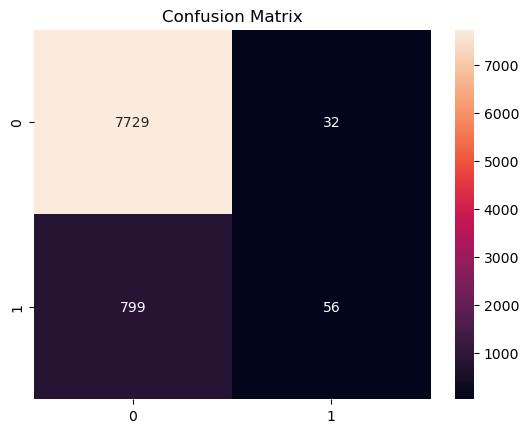

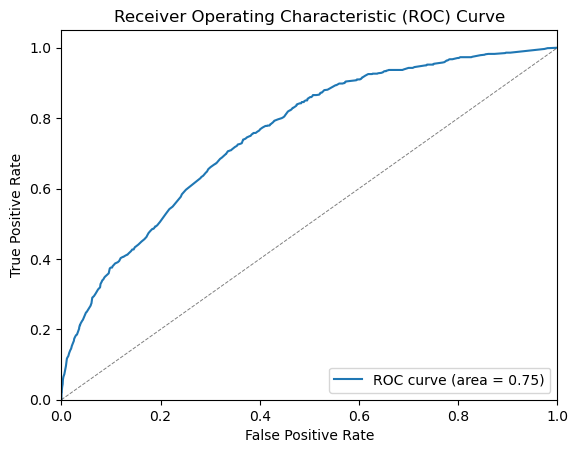

In [33]:
def evaluate_model_with_roc_curve_and_summary(model, X_test, y_test):
    # Start the timer
    start_time = time()

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert the continuous labels to binary labels
    y_pred_class = (y_pred > 0.5).astype(int)

    # Compute the ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred)

    # Compute the test accuracy
    test_acc = accuracy_score(y_test, y_pred_class)

    # Count the number of test examples and the number of correctly classified test examples
    num_test_examples = len(y_test)
    num_correctly_classified = test_acc * num_test_examples

    # Stop the timer
    end_time = time()

    # Print the summary of test set
    print("The test set contains {} examples (shots) of which {} are positive (goals).".format(num_test_examples, y_test.sum()))
    print("The accuracy of classifying whether a shot is goal or not is {:.2f}%.".format(test_acc * 100))

    # Print the evaluation results
    print("\nEvaluation results:")
    print("Number of correctly classified test examples: {}".format(int(num_correctly_classified)))
    print("Number of incorrectly classified test examples: {}".format(int(num_test_examples - num_correctly_classified)))
    print("ROC AUC: {:.2f}".format(roc_auc))

    # Compute the performance metrics
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    print("Precision: {:.2f}%".format(precision * 100))
    print("Recall: {:.2f}%".format(recall * 100))
    print("F1: {:.2f}%".format(f1 * 100))

    # Compute the PR-AUC
    average_precision = average_precision_score(y_test, y_pred)
    print("PR AUC: {:.2f}".format(average_precision))

    # Compute Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred_class)
    print("Cohen's Kappa: {:.2f}".format(kappa))

    print("Time taken to evaluate the model: {:.2f} seconds".format(end_time - start_time))


    # Print the classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_class))

    # Plot the confusion matrix
    confusion = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(confusion, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute and plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate the model on the validation set with ROC curve
evaluate_model_with_roc_curve_and_summary(model, dval, y_val)


The model is struggling to correctly classify the minority class (goals). This is a common issue when dealing with imbalanced datasets, where one class (no goal) vastly outnumbers the other (goal). 

In [34]:
# Get feature importances
feature_importances = model.get_score(importance_type='gain')

# Sort the features by their importance
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Print the features and their importances
for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: distance_to_goal, Importance: 16.087261199951172
Feature: angle_to_goal, Importance: 5.220418930053711


In [35]:
def save_model(dv, model, model_path):
    """
    Function to save the model.
    """
    if not os.path.exists(os.path.dirname(model_path)):
        os.makedirs(os.path.dirname(model_path))

    with open(model_path, 'wb') as f_out:
        joblib.dump((dv, model), f_out)

In [36]:
save_model(dv, model, 'models/xgb.bin')

NameError: name 'joblib' is not defined